Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 68, 68, 3)]      0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 60, 66, 66, 32)       896       ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 60, 33, 33, 32)       0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                              

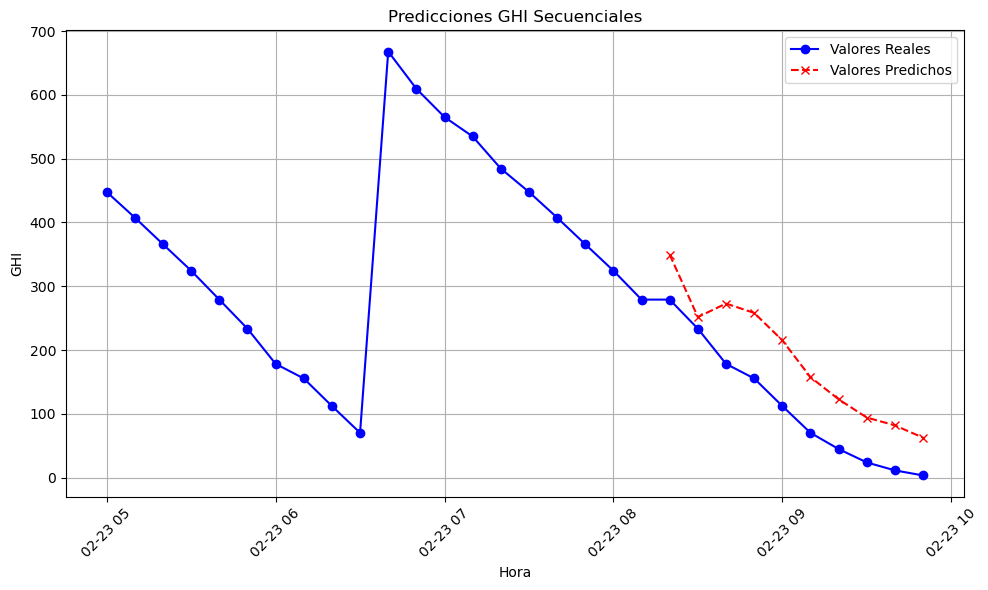

In [1]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Concatenate, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

df = pd.read_pickle('df_GHI.plk')

# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def timestamp_to_image_name(timestamp):
    return 'ACMF_' + timestamp.strftime('%Y%m%d_%H%M%S') + '.jpg'

# Asegúrate de que la columna 'Timestamp' sea de tipo datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filtrar el DataFrame por el rango de tiempo
fecha_inicio = '2022-02-23 05:00:00'
fecha_fin = '2022-02-23 18:20:00'
df_filtrado = df[(df['Timestamp'] >= fecha_inicio) & (df['Timestamp'] <= fecha_fin)]

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas a 68x68
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    
    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_name = timestamp_to_image_name(timestamp)
        image_path = f'{image_folder}/{image_name}'
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionar la imagen a 68x68 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (68, 68)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
        else:
            print(f"Imagen no encontrada: {image_path}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler

# Cargar imágenes y valores GHI
image_folder = 'Images/ACMF'
X_images, y_ghi, scaler = load_images_and_ghi(df_filtrado, image_folder)

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Parámetros del modelo
seq_len = 60  # Longitud de la secuencia de entrada
num_pred = 10  # Número de valores a predecir
X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

# Dividir los datos en conjunto de entrenamiento y prueba
X_images_seq_train, X_images_seq_test, X_ghi_seq_train, X_ghi_seq_test, y_ghi_pred_train, y_ghi_pred_test = train_test_split(
    X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42
)

# Definir el modelo CNN-LSTM ajustado para imágenes de 68x68 píxeles
img_shape = (68, 68, 3)

image_input = Input(shape=(seq_len, *img_shape))
cnn_model = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(image_input)
cnn_model = TimeDistributed(MaxPooling2D((2, 2)))(cnn_model)
cnn_model = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(cnn_model)
cnn_model = TimeDistributed(MaxPooling2D((2, 2)))(cnn_model)
cnn_model = TimeDistributed(Conv2D(128, (3, 3), activation='relu'))(cnn_model)
cnn_model = TimeDistributed(MaxPooling2D((2, 2)))(cnn_model)
cnn_model = TimeDistributed(Flatten())(cnn_model)

# Agregar una capa Dropout para prevenir sobreajuste
cnn_model = Dropout(0.3)(cnn_model)

numeric_input = Input(shape=(seq_len, 1))
concat = Concatenate()([cnn_model, numeric_input])

lstm_out = LSTM(64, return_sequences=False)(concat)

# Capa Dropout adicional para regularización
lstm_out = Dropout(0.3)(lstm_out)

output = Dense(num_pred)(lstm_out)

# Definir el modelo
model = Model([image_input, numeric_input], output)

# Compilar el modelo con un learning rate más bajo
model.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model.summary()

# Entrenar el modelo con el conjunto de entrenamiento
history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train, epochs=100, batch_size=32, validation_split=0.2)

# Predicción secuencial, avanzando en el tiempo
y_ghi_pred_test_sequential = []

# Asegurarse de que las secuencias de entrada estén correctamente avanzadas en el tiempo
for i in range(10):
    # Hacer una predicción usando la secuencia completa de 60 imágenes
    pred = model.predict([X_images_seq_test, X_ghi_seq_test])  # Predecir para la secuencia actual de 60 imágenes
    y_ghi_pred_test_sequential.append(pred.flatten())  # Almacenar la predicción
    
    # Avanzar en el tiempo actualizando los datos de entrada (desplazar 1 paso hacia adelante)
    X_images_seq_test = np.roll(X_images_seq_test, -1, axis=1)  # Desplazar la secuencia de imágenes hacia adelante
    X_ghi_seq_test = np.roll(X_ghi_seq_test, -1, axis=1)  # Desplazar la secuencia de GHI hacia adelante

# Convertir las predicciones secuenciales a un array
y_ghi_pred_test_sequential = np.concatenate(y_ghi_pred_test_sequential)

# Invertir la normalización de los valores predichos
y_ghi_pred_test_inversed = scaler.inverse_transform(y_ghi_pred_test_sequential.reshape(-1, 1)).flatten()

# Invertir la normalización de los valores reales para la prueba
y_ghi_test_inversed = scaler.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).flatten()

# Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
timestamps = pd.date_range(start='2022-02-23 05:00:00', periods=len(y_ghi_test_inversed), freq='10T')

# Función ajustada para graficar los valores reales y predichos de forma secuencial
def plot_real_vs_predicted(y_true, y_pred, timestamps, title="GHI: Predicciones vs Reales"):
    plt.figure(figsize=(10, 6))

    # Graficar los valores reales para todo el intervalo
    plt.plot(timestamps, y_true, label="Valores Reales", color='blue', marker='o')

    # Graficar los valores predichos de forma secuencial
    plt.plot(timestamps[-10:], y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')

    # Configuración del gráfico
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Graficar los resultados reales y predichos secuenciales
plot_real_vs_predicted(y_ghi_test_inversed, y_ghi_pred_test_inversed[-10:], timestamps, title="Predicciones GHI Secuenciales")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 60, 64, 64, 3)]      0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 60, 2, 2, 512)        1471468   ['input_2[0][0]']             
 ributed)                                                 8                                       
                                                                                                  
 time_distributed_1 (TimeDi  (None, 60, 2048)             0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                              

ValueError: x and y must have same first dimension, but have shapes (85,) and (850,)

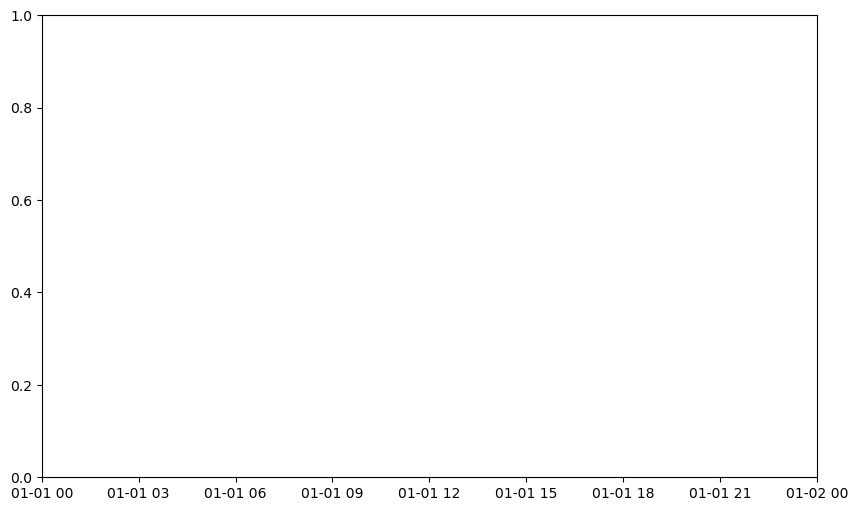

In [1]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def timestamp_to_image_name(timestamp):
    return 'ACMF_' + timestamp.strftime('%Y%m%d_%H%M%S') + '.jpg'

# Asegúrate de que la columna 'Timestamp' sea de tipo datetime
df = pd.read_pickle('df_GHI.plk')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filtrar el DataFrame por el rango de tiempo
fecha_inicio = '2023-07-01 05:00:00'
fecha_fin = '2023-07-02 18:20:00'
df_filtrado = df[(df['Timestamp'] >= fecha_inicio) & (df['Timestamp'] <= fecha_fin)]

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas a 64x64
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    
    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_name = timestamp_to_image_name(timestamp)
        image_path = f'{image_folder}/{image_name}'
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionar la imagen a 64x64 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
        else:
            print(f"Imagen no encontrada: {image_path}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler

# Cargar imágenes y valores GHI
image_folder = 'Images/ACMF'
X_images, y_ghi, scaler = load_images_and_ghi(df_filtrado, image_folder)

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Parámetros del modelo
seq_len = 60  # Longitud de la secuencia de entrada
num_pred = 10  # Número de valores a predecir
X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

# Dividir los datos en conjunto de entrenamiento y prueba
X_images_seq_train, X_images_seq_test, X_ghi_seq_train, X_ghi_seq_test, y_ghi_pred_train, y_ghi_pred_test = train_test_split(
    X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42
)

# Definir el modelo VGG16 personalizado ajustado para imágenes de 64x64
vgg16_base = VGG16(weights=None, include_top=False, input_shape=(64, 64, 3))  # Sin pesos preentrenados para 64x64

# Aplicar VGG16 a cada imagen de la secuencia usando TimeDistributed
image_input = Input(shape=(seq_len, 64, 64, 3))  # Input de secuencias de imágenes de 64x64
vgg16_features = TimeDistributed(vgg16_base)(image_input)

# Aplanar las características obtenidas de VGG16
vgg16_features = TimeDistributed(Flatten())(vgg16_features)

# Entrada numérica (valores GHI previos)
numeric_input = Input(shape=(seq_len, 1))

# Concatenar las características de VGG16 con los valores numéricos
concat = Concatenate()([vgg16_features, numeric_input])

# Pasar las características concatenadas a LSTM
lstm_out = LSTM(64, return_sequences=False)(concat)

# Agregar Dropout para regularización
lstm_out = Dropout(0.3)(lstm_out)

# Capa densa para hacer la predicción de GHI (10 valores futuros)
output = Dense(num_pred)(lstm_out)

# Definir el modelo completo
model = Model([image_input, numeric_input], output)

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model.summary()

# Entrenar el modelo con el conjunto de entrenamiento
history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train, epochs=30, batch_size=32, validation_split=0.2)

# Hacer predicciones con el conjunto de prueba
y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])

# Invertir la normalización de los valores predichos
y_ghi_pred_test_inversed = scaler.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
y_ghi_test_inversed = scaler.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)

# Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
timestamps = pd.date_range(start='2022-02-23 05:00:00', periods=len(y_ghi_test_inversed), freq='10T')

# Función para graficar los valores reales y predichos de forma secuencial
def plot_real_vs_predicted(y_true, y_pred, timestamps, title="GHI: Predicciones vs Reales"):
    plt.figure(figsize=(10, 6))

    # Graficar los valores reales
    plt.plot(timestamps, y_true, label="Valores Reales", color='blue', marker='o')

    # Graficar los valores predichos
    plt.plot(timestamps[-10:], y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')

    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Graficar los resultados predichos vs los valores reales
plot_real_vs_predicted(y_ghi_test_inversed.flatten(), y_ghi_pred_test_inversed.flatten(), timestamps, title="Predicciones GHI Secuenciales")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 64, 64, 3)]      0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 30, 2, 2, 512)        1471468   ['input_2[0][0]']             
 ributed)                                                 8                                       
                                                                                                  
 time_distributed_1 (TimeDi  (None, 30, 2048)             0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                              

ValueError: x and y must have same first dimension, but have shapes (41,) and (410,)

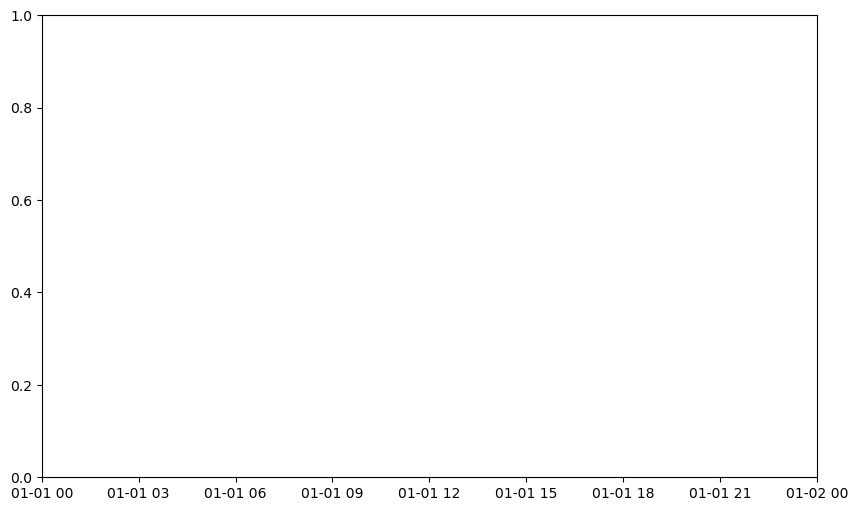

In [1]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def timestamp_to_image_name(timestamp):
    return 'ACMF_' + timestamp.strftime('%Y%m%d_%H%M%S') + '.jpg'

# Asegúrate de que la columna 'Timestamp' sea de tipo datetime
df = pd.read_pickle('df_GHI.plk')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filtrar el DataFrame por un rango de tiempo más pequeño para acelerar el entrenamiento
fecha_inicio = '2023-07-01 05:00:00'
fecha_fin = '2023-07-03 18:20:00'  # Reducido a 3 días para disminuir la carga de datos
df_filtrado = df[(df['Timestamp'] >= fecha_inicio) & (df['Timestamp'] <= fecha_fin)]

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas a 64x64
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    
    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_name = timestamp_to_image_name(timestamp)
        image_path = f'{image_folder}/{image_name}'
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionar la imagen a 64x64 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
        else:
            print(f"Imagen no encontrada: {image_path}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler

# Cargar imágenes y valores GHI
image_folder = 'Images/ACMF'
X_images, y_ghi, scaler = load_images_and_ghi(df_filtrado, image_folder)

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Parámetros del modelo
seq_len = 30  # Reducido de 60 a 30 para acelerar el entrenamiento
num_pred = 10  # Número de valores a predecir
X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

# Dividir los datos en conjunto de entrenamiento y prueba
X_images_seq_train, X_images_seq_test, X_ghi_seq_train, X_ghi_seq_test, y_ghi_pred_train, y_ghi_pred_test = train_test_split(
    X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42
)

# Definir el modelo VGG16 personalizado ajustado para imágenes de 64x64
vgg16_base = VGG16(weights=None, include_top=False, input_shape=(64, 64, 3))  # Sin pesos preentrenados para 64x64

# Aplicar VGG16 a cada imagen de la secuencia usando TimeDistributed
image_input = Input(shape=(seq_len, 64, 64, 3))  # Input de secuencias de imágenes de 64x64
vgg16_features = TimeDistributed(vgg16_base)(image_input)

# Aplanar las características obtenidas de VGG16
vgg16_features = TimeDistributed(Flatten())(vgg16_features)

# Entrada numérica (valores GHI previos)
numeric_input = Input(shape=(seq_len, 1))

# Concatenar las características de VGG16 con los valores numéricos
concat = Concatenate()([vgg16_features, numeric_input])

# Pasar las características concatenadas a LSTM
lstm_out = LSTM(64, return_sequences=False)(concat)

# Agregar Dropout para regularización
lstm_out = Dropout(0.3)(lstm_out)

# Capa densa para hacer la predicción de GHI (10 valores futuros)
output = Dense(num_pred)(lstm_out)

# Definir el modelo completo
model = Model([image_input, numeric_input], output)

# Compilar el modelo
model.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model.summary()

# Entrenar el modelo con el conjunto de entrenamiento
history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train, epochs=30, batch_size=32, validation_split=0.2)  # Reducción en el número de épocas

# Hacer predicciones con el conjunto de prueba
y_ghi_pred_test = model.predict([X_images_seq_test, X_ghi_seq_test])

# Invertir la normalización de los valores predichos
y_ghi_pred_test_inversed = scaler.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)
y_ghi_test_inversed = scaler.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).reshape(-1, num_pred)

# Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
timestamps = pd.date_range(start='2023-07-03 05:00:00', periods=len(y_ghi_test_inversed), freq='10T')

# Función para graficar los valores reales y predichos de forma secuencial
def plot_real_vs_predicted(y_true, y_pred, timestamps, title="GHI: Predicciones vs Reales"):
    plt.figure(figsize=(10, 6))

    # Graficar los valores reales
    plt.plot(timestamps, y_true, label="Valores Reales", color='blue', marker='o')

    # Graficar los valores predichos
    plt.plot(timestamps[-10:], y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')

    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Graficar los resultados predichos vs los valores reales
plot_real_vs_predicted(y_ghi_test_inversed.flatten(), y_ghi_pred_test_inversed.flatten(), timestamps, title="Predicciones GHI Secuenciales")


Dimensiones de y_ghi_test_inversed: (410,)
Dimensiones de y_ghi_pred_test_inversed: (410,)
Dimensiones de timestamps: (410,)


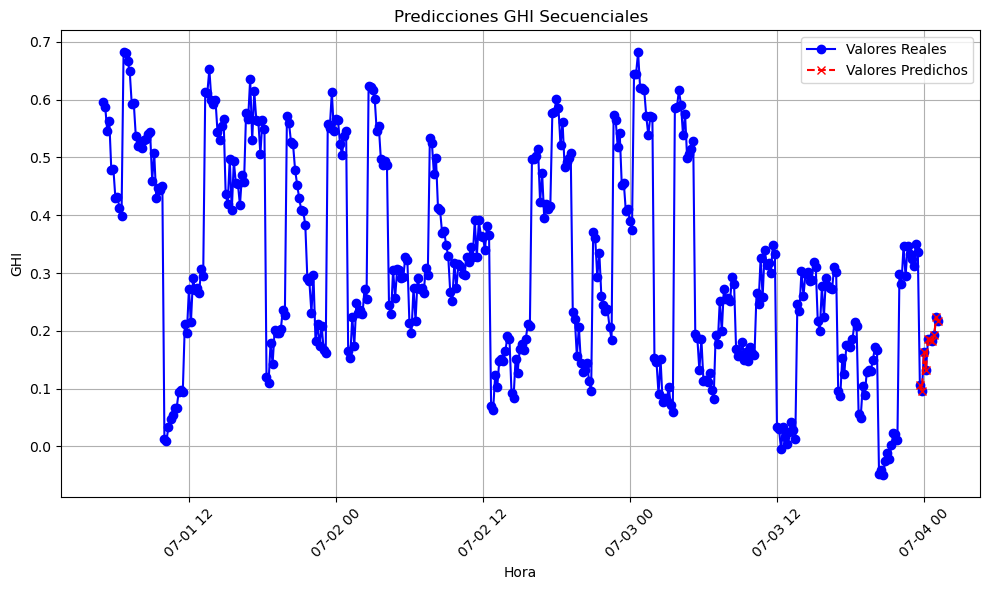

In [2]:
# Asegúrate de que la longitud de timestamps coincida con el número de valores reales y predichos
num_samples = len(y_ghi_test_inversed.flatten())  # El número de valores reales/predichos
timestamps = pd.date_range(start='2023-07-01 05:00:00', periods=num_samples, freq='10T')

# Verificar las dimensiones de los datos
print(f"Dimensiones de y_ghi_test_inversed: {y_ghi_test_inversed.flatten().shape}")
print(f"Dimensiones de y_ghi_pred_test_inversed: {y_ghi_pred_test_inversed.flatten().shape}")
print(f"Dimensiones de timestamps: {timestamps.shape}")

# Función para graficar los valores reales y predichos de forma secuencial
def plot_real_vs_predicted(y_true, y_pred, timestamps, title="GHI: Predicciones vs Reales"):
    plt.figure(figsize=(10, 6))

    # Graficar los valores reales
    plt.plot(timestamps, y_true, label="Valores Reales", color='blue', marker='o')

    # Graficar los valores predichos
    plt.plot(timestamps[-10:], y_pred[-10:], label="Valores Predichos", color='red', linestyle='--', marker='x')

    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Asegurarse de que las longitudes coincidan
y_true = y_ghi_test_inversed.flatten()
y_pred = y_ghi_pred_test_inversed.flatten()

# Graficar los resultados predichos vs los valores reales
plot_real_vs_predicted(y_true, y_pred, timestamps, title="Predicciones GHI Secuenciales")

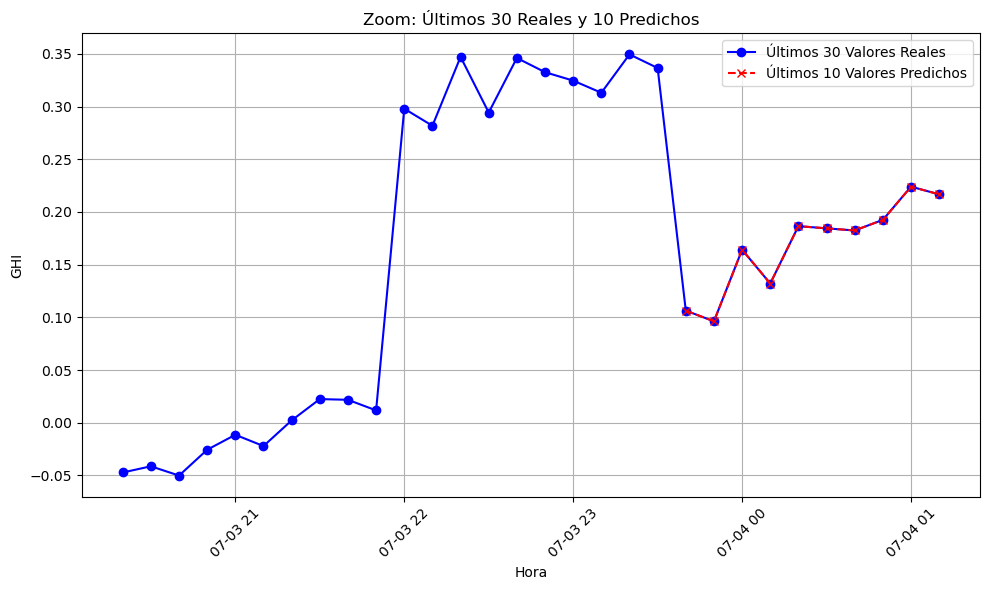

In [3]:
# Función para graficar los últimos 30 valores reales y los últimos 10 predichos
def plot_zoomed_real_vs_predicted(y_true, y_pred, timestamps, title="Zoom: Últimos 30 Reales y 10 Predichos"):
    plt.figure(figsize=(10, 6))

    # Graficar los últimos 30 valores reales
    plt.plot(timestamps[-30:], y_true[-30:], label="Últimos 30 Valores Reales", color='blue', marker='o')

    # Graficar los últimos 10 valores predichos
    plt.plot(timestamps[-10:], y_pred[-10:], label="Últimos 10 Valores Predichos", color='red', linestyle='--', marker='x')

    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Graficar los últimos 30 valores reales y los últimos 10 predichos
plot_zoomed_real_vs_predicted(y_true, y_pred, timestamps, title="Zoom: Últimos 30 Reales y 10 Predichos")

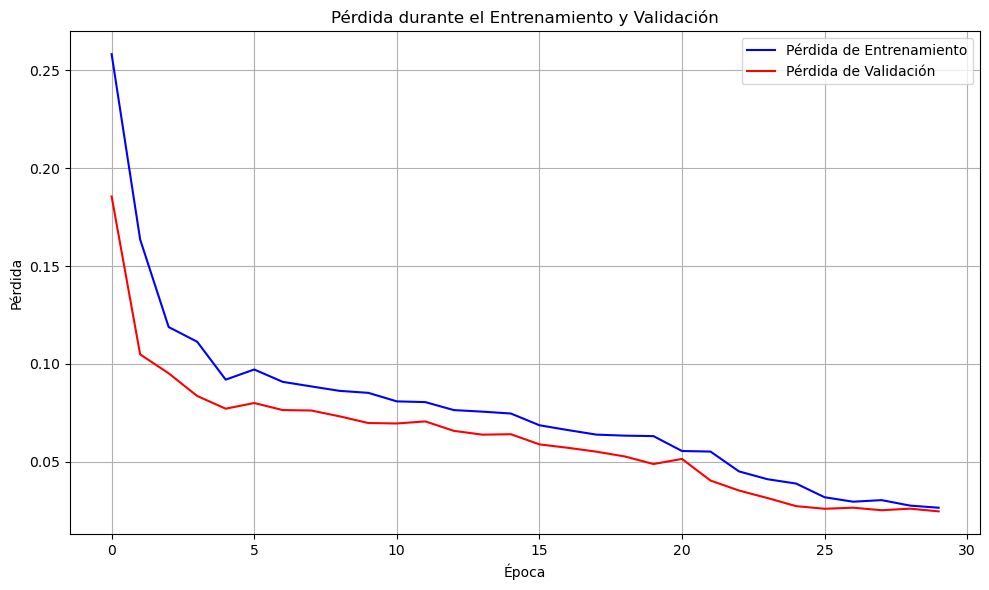

In [4]:
# Función para graficar la pérdida (entrenamiento y validación)
def plot_loss(history, title="Pérdida durante el Entrenamiento y Validación"):
    plt.figure(figsize=(10, 6))
    
    # Graficar la pérdida del entrenamiento
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento', color='blue')
    
    # Graficar la pérdida de validación (si está disponible)
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Pérdida de Validación', color='red')
    
    # Configuración del gráfico
    plt.title(title)
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

# Llamar a la función para graficar la pérdida
plot_loss(history)


In [7]:
# Compilar el modelo con una métrica adicional de error absoluto medio (MAE)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


2/2 [==============================] - 7s 1s/step


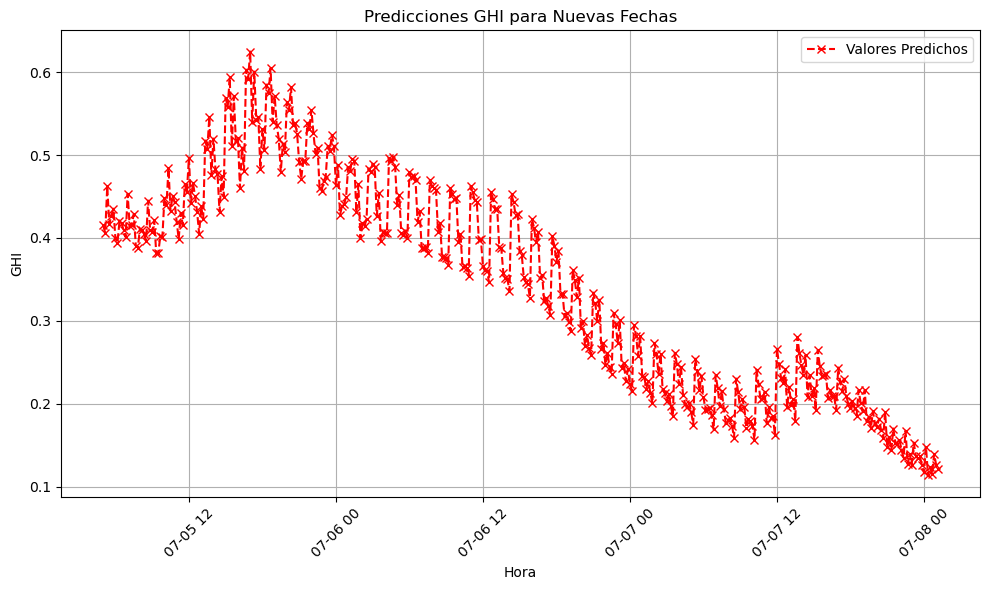

In [8]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def timestamp_to_image_name(timestamp):
    return 'ACMF_' + timestamp.strftime('%Y%m%d_%H%M%S') + '.jpg'

# Asegúrate de que la columna 'Timestamp' sea de tipo datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filtrar el DataFrame por el nuevo rango de tiempo
fecha_inicio = '2023-07-05 05:00:00'  # Nueva fecha de inicio
fecha_fin = '2023-07-05 18:20:00'  # Nueva fecha de fin
df_nuevas_fechas = df[(df['Timestamp'] >= fecha_inicio) & (df['Timestamp'] <= fecha_fin)]

# Cargar imágenes y valores GHI normalizados
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    
    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_name = timestamp_to_image_name(timestamp)
        image_path = f'{image_folder}/{image_name}'
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionar la imagen a 64x64 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
        else:
            print(f"Imagen no encontrada: {image_path}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler

# Cargar las imágenes y GHI para las nuevas fechas
image_folder = 'Images/ACMF'  # Ruta donde se encuentran las imágenes
X_images_new, y_ghi_new, scaler_new = load_images_and_ghi(df_nuevas_fechas, image_folder)

# Crear secuencias para las nuevas fechas (usando imágenes y valores GHI)
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Parámetros del modelo
seq_len = 30  # Longitud de la secuencia de entrada
num_pred = 10  # Número de valores a predecir

# Crear secuencias de entrada y salida para las nuevas fechas
X_images_seq_new, X_ghi_seq_new, y_ghi_pred_new = create_sequences(X_images_new, y_ghi_new, seq_len, num_pred)

# Hacer predicciones con el modelo para las nuevas fechas
y_ghi_pred_new = model.predict([X_images_seq_new, X_ghi_seq_new])

# Invertir la normalización de los valores predichos
y_ghi_pred_new_inversed = scaler_new.inverse_transform(y_ghi_pred_new.reshape(-1, 1)).reshape(-1, num_pred)

# Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
num_samples_new = len(y_ghi_pred_new_inversed.flatten())
timestamps_new = pd.date_range(start=fecha_inicio, periods=num_samples_new, freq='10T')

# Función para graficar los valores predichos para las nuevas fechas
def plot_new_predictions(timestamps, y_pred, title="Predicciones GHI para Nuevas Fechas"):
    plt.figure(figsize=(10, 6))
    
    # Graficar los valores predichos
    plt.plot(timestamps, y_pred.flatten(), label="Valores Predichos", color='red', linestyle='--', marker='x')
    
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

# Graficar los resultados predichos para las nuevas fechas
plot_new_predictions(timestamps_new, y_ghi_pred_new_inversed, title="Predicciones GHI para Nuevas Fechas")


3/3 [==============================] - 11s 3s/step


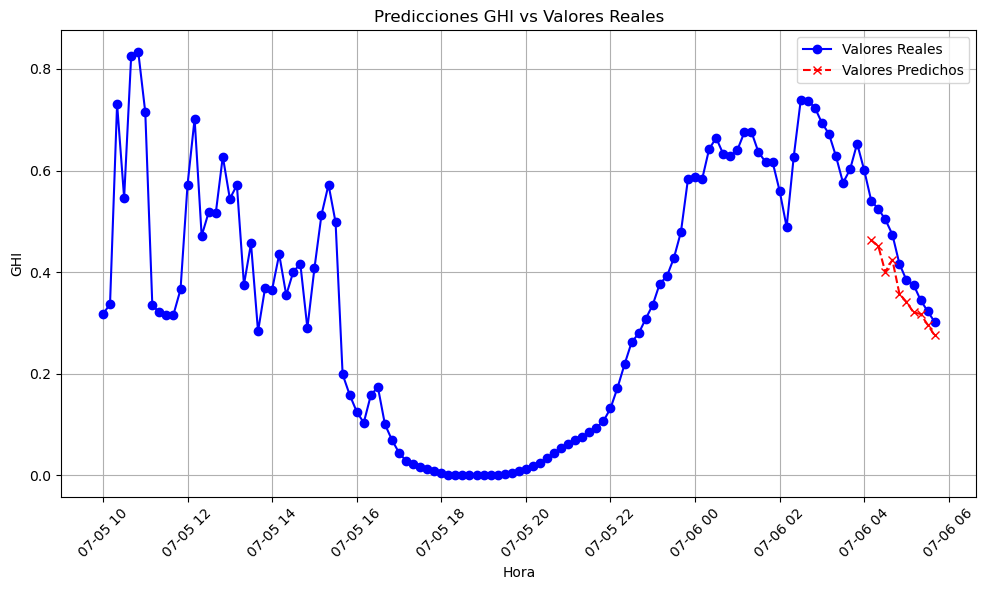

In [14]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, TimeDistributed, Concatenate, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def timestamp_to_image_name(timestamp):
    return 'ACMF_' + timestamp.strftime('%Y%m%d_%H%M%S') + '.jpg'

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas a 64x64
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    
    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_name = timestamp_to_image_name(timestamp)
        image_path = f'{image_folder}/{image_name}'
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionar la imagen a 64x64 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (64, 64)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
        else:
            print(f"Imagen no encontrada: {image_path}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Función para graficar las predicciones junto con los valores reales
def plot_real_vs_predicted(timestamps, y_real, y_pred, title="Predicciones GHI vs Reales"):
    plt.figure(figsize=(10, 6))
    
    # Graficar los valores reales (limitar a la longitud de los predichos si es necesario)
    plt.plot(timestamps[:len(y_real.flatten())], y_real.flatten(), label="Valores Reales", color='blue', marker='o')
    
    # Graficar los valores predichos (limitar a los últimos num_pred valores)
    plt.plot(timestamps[-num_pred:], y_pred.flatten()[-num_pred:], label="Valores Predichos", color='red', linestyle='--', marker='x')
    
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

# --------------------------------------------------------------------------------------------

# Filtrar el DataFrame por el nuevo rango de tiempo para las nuevas fechas
fecha_inicio = '2023-07-05 10:00:00'  # Nueva fecha de inicio
fecha_fin = '2023-07-06 16:00:00'  # Nueva fecha de fin
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Asegurar que la columna Timestamp sea de tipo datetime
df_nuevas_fechas = df[(df['Timestamp'] >= fecha_inicio) & (df['Timestamp'] <= fecha_fin)]

# Cargar imágenes y valores GHI para las nuevas fechas
image_folder = 'Images/ACMF'
X_images_new, y_ghi_new, scaler_new = load_images_and_ghi(df_nuevas_fechas, image_folder)

# Parámetros del modelo
seq_len = 30  # Longitud de la secuencia de entrada
num_pred = 10  # Número de valores a predecir

# Crear secuencias de entrada y salida con las nuevas imágenes y valores GHI
X_images_seq_new, X_ghi_seq_new, y_ghi_pred_new = create_sequences(X_images_new, y_ghi_new, seq_len, num_pred)

# Hacer predicciones con el modelo en las nuevas secuencias
y_ghi_pred_new = model.predict([X_images_seq_new, X_ghi_seq_new])

# Invertir la normalización de los valores predichos y reales
y_ghi_pred_new_inversed = scaler_new.inverse_transform(y_ghi_pred_new.reshape(-1, 1)).reshape(-1, num_pred)
y_ghi_new_inversed = scaler_new.inverse_transform(y_ghi_new.reshape(-1, 1))

# Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
timestamps_new = pd.date_range(start=fecha_inicio, periods=len(y_ghi_new_inversed), freq='10T')

# Graficar los resultados predichos y reales para las nuevas fechas
plot_real_vs_predicted(timestamps_new, y_ghi_new_inversed, y_ghi_pred_new_inversed, title="Predicciones GHI vs Valores Reales")
